# GCN Pytorch Geometric

Learning and running examples from:
- https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html
- https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=1tBMhOrq4JKw
- https://colab.research.google.com/drive/1XAjcjRHrSR_ypCk_feIWFbcBKyT4Lirs#scrollTo=RwuwXWLZ_4OQ
- https://networkrepository.com/Mutag.php

In [5]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [15]:
import time
from rich.progress import track

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in  track(range(10), description="Processing..."):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

Output()

In [16]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7750


In [17]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

# Graph Classification Pytorch Geometrics

In [1]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [2]:
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import numpy as np

In [30]:
data = dataset[1]
G = to_networkx(data, to_undirected=True)

threshold 0.16666666666666666
tensor([[  0,   0,   1,  ..., 384, 385, 386],
        [  1,   5,   0,  ..., 386, 384, 384]])


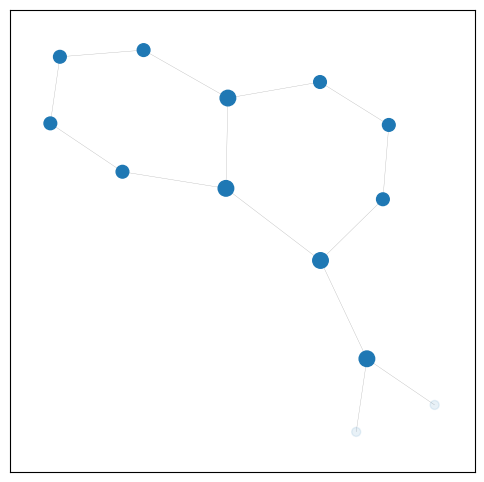

In [20]:
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(6, 6))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.inferno,
                               #node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
                                
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
print(data.edge_index)
plt.show()

In [15]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [16]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



In [21]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [67]:
from rich.progress import track

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        correct
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in track(range(1, 171), description="Training..."):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Output()

AttributeError: 'int' object has no attribute 'cpu'

In [64]:
device = 'cpu'
data.to(device)

Data(edge_index=[2, 20], x=[10, 7], edge_attr=[20, 4], y=[1])

In [57]:
dataset.url

'https://www.chrsmrrs.com/graphkerneldatasets'

data

In [68]:
torch.save(model.state_dict(), 'model')

In [69]:
import wandb

ModuleNotFoundError: No module named 'wandb'

In [ ]:
t